In [1]:
# Create the Spark Session Object
!pip install pyspark
from pyspark.sql import SparkSession
spark=SparkSession.builder.appName('EDA').getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=d9bfcda58da768d7712c25f5a5b86a131452de1a1c086db9b51f38351d675254
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


Dataset: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing
Aim: To select the best features in dataset using the different variable selection techniques and to avoid multicollinearity.

In built (Without Target -> PCA, SVD/ With Target -> Chi Square, Random Forest)

Custom built (Custom Transformers, Voting Based selection)

EDA is a process used to analyze data to identify the characteristics and patterns existing in that data using summarization or visualization.

Data could be missing due to:
1. MAR: there is a relationship between the missing data and the observed data
2. MCAR: there is no relationship between ... Imputing is a way of filling in missing values in data science
3. MNAR: the data is not collected


   # Input variables:
   #### Bank client data:
   1 - age (numeric)
   2 - job : type of job (categorical)
   3 - marital : marital status (categorical)
   4 - education (categorical)
   5 - default: has credit in default? (binary: "yes","no")
   6 - balance: average yearly balance, in euros (numeric)
   7 - housing: has housing loan? (binary: "yes","no")
   8 - loan: has personal loan? (binary: "yes","no")
   #### Related with the last contact of the current campaign:
   9 - contact: contact communication type (categorical)
  10 - day: last contact day of the month (numeric)
  11 - month: last contact month of year (categorical)
  12 - duration: last contact duration, in seconds (numeric)
   #### Other attributes:
  13 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  14 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
  
  15 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  16 - poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

  Output variable (desired target):
  17 - y - has the client subscribed a term deposit? (binary: "yes","no")

# Exploratory Data Analysis
To identify the characteristics and patterns using summarization or visualization.

In [2]:
filename = "bank-full.csv"
target_variable_name = "y" #This variable can be set later too

In [3]:
df=spark.read.csv('sample_data/bank-full.csv', header=True, inferSchema=True, sep=';')

In [4]:
df.show(10)

+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
|age|         job| marital|education|default|balance|housing|loan|contact|day|month|duration|campaign|pdays|previous|poutcome|  y|
+---+------------+--------+---------+-------+-------+-------+----+-------+---+-----+--------+--------+-----+--------+--------+---+
| 58|  management| married| tertiary|     no|   2143|    yes|  no|unknown|  5|  may|     261|       1|   -1|       0| unknown| no|
| 44|  technician|  single|secondary|     no|     29|    yes|  no|unknown|  5|  may|     151|       1|   -1|       0| unknown| no|
| 33|entrepreneur| married|secondary|     no|      2|    yes| yes|unknown|  5|  may|      76|       1|   -1|       0| unknown| no|
| 47| blue-collar| married|  unknown|     no|   1506|    yes|  no|unknown|  5|  may|      92|       1|   -1|       0| unknown| no|
| 33|     unknown|  single|  unknown|     no|      1|     no|  no|unknown|  5|  may

In [5]:
print((df.count(), len(df.columns)))

(45211, 17)


In [6]:
#describes data
df.describe().toPandas() #missing and cardinality followup

,summary,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,count,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211,45211
1,mean,40.93621021432837,None,None,None,None,1362.2720576850766,None,None,None,15.80641879188693,None,258.1630797814691,2.763840658246887,40.19782796222158,0.5803233726305546,None,None
2,stddev,10.618762040975408,None,None,None,None,3044.7658291685243,None,None,None,8.322476153044596,None,257.52781226517095,3.098020883279184,100.12874599059813,2.3034410449312204,None,None
3,min,18,admin.,divorced,primary,no,-8019,no,no,cellular,1,apr,0,1,-1,0,failure,no
4,max,95,unknown,single,unknown,yes,102127,yes,yes,unknown,31,sep,4918,63,871,275,unknown,yes


In [7]:
#type of each variable
df.dtypes
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- y: string (nullable = true)



In [8]:
#single variable count by group
df.groupBy('education').count().show()

+---------+-----+
|education|count|
+---------+-----+
|  unknown| 1857|
| tertiary|13301|
|secondary|23202|
|  primary| 6851|
+---------+-----+



In [9]:
#target count
df.groupBy(target_variable_name).count().show()

+---+-----+
|  y|count|
+---+-----+
| no|39922|
|yes| 5289|
+---+-----+



In [10]:
#multiple column group by
df.groupBy(['education',target_variable_name]).count().show()

+---------+---+-----+
|education|  y|count|
+---------+---+-----+
|  unknown| no| 1605|
| tertiary| no|11305|
|secondary| no|20752|
|  unknown|yes|  252|
|  primary| no| 6260|
|  primary|yes|  591|
|secondary|yes| 2450|
| tertiary|yes| 1996|
+---------+---+-----+



In [11]:
#column aggregations
from pyspark.sql.functions import *
df.groupBy(target_variable_name).agg({'balance':'avg', 'age': 'avg'}).show()

+---+------------------+------------------+
|  y|      avg(balance)|          avg(age)|
+---+------------------+------------------+
| no|1303.7149691899203| 40.83898602274435|
|yes|1804.2679145396105|41.670069956513515|
+---+------------------+------------------+



In [12]:
# Cardinality Check
from pyspark.sql.functions import approxCountDistinct, countDistinct
"""
Note: approxCountDistinct and countDistinct can be used interchangeably. Only difference is the computation time.
"approxCountDistinct" is useful for large datasets
"countDistinct" for small and medium datasets.
"""

def cardinality_calculation(df, cut_off=1):
    cardinality = df.select(*[approx_count_distinct(c).alias(c) for c in df.columns])

    ## convert to pandas for efficient calculations
    final_cardinality_df = cardinality.toPandas().transpose()
    final_cardinality_df.reset_index(inplace=True)
    final_cardinality_df.rename(columns={0:'Cardinality'}, inplace=True)

    #select variables with cardinality of 1
    vars_selected = final_cardinality_df['index']
    [final_cardinality_df['Cardinality'] <= cut_off]

    return final_cardinality_df, vars_selected

cardinality_df, cardinality_vars_selected = cardinality_calculation(df)

In [13]:
# Cardinality is the number of unique values of a variable.
cardinality_calculation(df)

(        index  Cardinality
 0         age           76
 1         job           11
 2     marital            3
 3   education            4
 4     default            2
 5     balance         7375
 6     housing            2
 7        loan            2
 8     contact            3
 9         day           32
 10      month           12
 11   duration         1605
 12   campaign           47
 13      pdays          547
 14   previous           42
 15   poutcome            4
 16          y            2,
 0           age
 1           job
 2       marital
 3     education
 4       default
 5       balance
 6       housing
 7          loan
 8       contact
 9           day
 10        month
 11     duration
 12     campaign
 13        pdays
 14     previous
 15     poutcome
 16            y
 Name: index, dtype: object)

In [14]:
#missing values check
from pyspark.sql.functions import count, when, isnan, col

# miss_percentage is set to 80% as discussed in the book
def missing_calculation(df, miss_percentage=0.80):
    #checks for both NaN and null values
    missing = df.select(*[count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
    length_df = df.count()
    ## convert to pandas for efficient calculations
    final_missing_df = missing.toPandas().transpose()
    final_missing_df.reset_index(inplace=True)
    final_missing_df.rename(columns={0:'missing_count'}, inplace=True)
    final_missing_df['missing_percentage'] = final_missing_df['missing_count']/length_df

    #select variables with cardinality of 1
    vars_selected = final_missing_df['index'][final_missing_df['missing_percentage'] >= miss_percentage]

    return final_missing_df, vars_selected

missing_df, missing_vars_selected = missing_calculation(df)

In [15]:
missing_calculation(df)
# No columns are rejected based on these 2 checks

(        index  missing_count  missing_percentage
 0         age              0                 0.0
 1         job              0                 0.0
 2     marital              0                 0.0
 3   education              0                 0.0
 4     default              0                 0.0
 5     balance              0                 0.0
 6     housing              0                 0.0
 7        loan              0                 0.0
 8     contact              0                 0.0
 9         day              0                 0.0
 10      month              0                 0.0
 11   duration              0                 0.0
 12   campaign              0                 0.0
 13      pdays              0                 0.0
 14   previous              0                 0.0
 15   poutcome              0                 0.0
 16          y              0                 0.0,
 Series([], Name: index, dtype: object))

Selection techniques: 1. Cardinality 2. Missing value 3. Convert all the columns to numbers (OneHotEncoder, StringIndexer from pyspark.ml.feature, Weighted index)

In [16]:
# Step 1: Identify variable types
def variable_type(df):
    # use the dtypes to separate character and numeric variables
    vars_list = df.dtypes
    char_vars = [] #character variables list
    num_vars = [] #numeric variable list
    for i in vars_list:
        if i[1] in ('string'):
            char_vars.append(i[0])
        else:
            num_vars.append(i[0])

    return char_vars, num_vars

#apply variable_type function on our DataFrame
char_vars, num_vars = variable_type(df)

In [17]:
variable_type(df)

(['job',
  'marital',
  'education',
  'default',
  'housing',
  'loan',
  'contact',
  'month',
  'poutcome',
  'y'],
 ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'])

In [18]:
# Step 2: Apply StringIndexer to Character Columns
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline

#converts each category column to index
def category_to_index(df, char_vars):

    char_df = df.select(char_vars)
    indexers = [StringIndexer(inputCol=c, outputCol=c+"_index",
               handleInvalid="keep") for c in char_df.columns]
    pipeline = Pipeline(stages=indexers)
    char_labels = pipeline.fit(char_df)
    df = char_labels.transform(df) #?
    return df, char_labels

#apply category_to_index function on our DataFrame
df, char_labels = category_to_index(df, char_vars)

In [19]:
df = df.select([c for c in df.columns if c not in char_vars])

In [20]:
print(df)

DataFrame[age: int, balance: int, day: int, duration: int, campaign: int, pdays: int, previous: int, job_index: double, marital_index: double, education_index: double, default_index: double, housing_index: double, loan_index: double, contact_index: double, month_index: double, poutcome_index: double, y_index: double]


In [21]:
#rename _index columns to original variable name
def rename_columns(df, char_vars):
    mapping = dict(zip([i + '_index' for i in char_vars], char_vars))
    df = df.select([col(c).alias(mapping.get(c, c)) for c in df.columns])
    return df

# apply rename_columns to our DataFrame
df = rename_columns(df, char_vars)

In [22]:
rename_columns(df, char_vars)
# The DataFrame is now completely numeric.

DataFrame[age: int, balance: int, day: int, duration: int, campaign: int, pdays: int, previous: int, job: double, marital: double, education: double, default: double, housing: double, loan: double, contact: double, month: double, poutcome: double, y: double]

In [23]:
# Step 3: Assemble features into one vector
from pyspark.ml.feature import VectorAssembler

#assemble individual columns to one column - 'features'
def assemble_vectors(df, features_list, target_variable_name):
    stages = []
    #assemble vectors
    assembler = VectorAssembler(inputCols=features_list,
    outputCol='features')
    stages = [assembler]
    #select all the columns + target + newly created 'features' column
    selectedCols = [target_variable_name, 'features'] + features_list
    #use pipeline to process sequentially
    pipeline = Pipeline(stages=stages)
    #assembler model
    assembleModel = pipeline.fit(df)
    #apply assembler model on data
    df = assembleModel.transform(df).select(selectedCols)
    return df

# exclude target variable and select all other feature vectors
features_list = df.columns
features_list.remove(target_variable_name)

# apply the function on our DataFrame
df = assemble_vectors(df, features_list, target_variable_name)

In [24]:
df.schema["features"].metadata["ml_attr"]["attrs"]

{'numeric': [{'idx': 0, 'name': 'age'},
  {'idx': 1, 'name': 'balance'},
  {'idx': 2, 'name': 'day'},
  {'idx': 3, 'name': 'duration'},
  {'idx': 4, 'name': 'campaign'},
  {'idx': 5, 'name': 'pdays'},
  {'idx': 6, 'name': 'previous'}],
 'nominal': [{'vals': ['blue-collar',
    'management',
    'technician',
    'admin.',
    'services',
    'retired',
    'self-employed',
    'entrepreneur',
    'unemployed',
    'housemaid',
    'student',
    'unknown',
    '__unknown'],
   'idx': 7,
   'name': 'job'},
  {'vals': ['married', 'single', 'divorced', '__unknown'],
   'idx': 8,
   'name': 'marital'},
  {'vals': ['secondary', 'tertiary', 'primary', 'unknown', '__unknown'],
   'idx': 9,
   'name': 'education'},
  {'vals': ['no', 'yes', '__unknown'], 'idx': 10, 'name': 'default'},
  {'vals': ['yes', 'no', '__unknown'], 'idx': 11, 'name': 'housing'},
  {'vals': ['no', 'yes', '__unknown'], 'idx': 12, 'name': 'loan'},
  {'vals': ['cellular', 'unknown', 'telephone', '__unknown'],
   'idx': 13,


In [25]:
import pandas as pd
for k, v in df.schema["features"].metadata["ml_attr"]["attrs"].items():
    features_df = pd.DataFrame(v)
    print(features_df)
#  The DataFrame (df) must be compatible with the downstream task

   idx      name
0    0       age
1    1   balance
2    2       day
3    3  duration
4    4  campaign
5    5     pdays
6    6  previous
                                                vals  idx       name
0  [blue-collar, management, technician, admin., ...    7        job
1             [married, single, divorced, __unknown]    8    marital
2  [secondary, tertiary, primary, unknown, __unkn...    9  education
3                               [no, yes, __unknown]   10    default
4                               [yes, no, __unknown]   11    housing
5                               [no, yes, __unknown]   12       loan
6          [cellular, unknown, telephone, __unknown]   13    contact
7  [may, jul, aug, jun, nov, apr, feb, jan, oct, ...   14      month
8      [unknown, failure, other, success, __unknown]   15   poutcome


# Built-in Variable Selection Process: Without Target
To reduce the dimension of the data without an explicit target (data compression).

PCA identify patterns in large datasets that can recognize the variables that contain the most information. It guide us in identifying the variable that is most important to the clustering  of variables. It finds the best-fitting line by maximizing the sum of the squared distances from the projected points to the origin. If the variable distribution is all centered close to the mean, it usually contains tiny information.

Eigenvalues are the sum of squares of the distances between the projected points and the origins of the identified PCs.

The mean of both variables are calculated.

In [26]:
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors
no_of_components = 3 #custom number
pca = PCA(k=no_of_components, inputCol="features", outputCol="pcaFeatures")
model = pca.fit(df)
result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

# pcaFeatures is the reduced set of features produced by the PCA alogorithm that can be used in the downstream ML process

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-2143.4953647735815,-257.0420740676505,1.244971275304795]  |
|[-29.2922617516463,-150.92888640669167,1.0493026899279936]  |
|[-2.150889773941893,-75.98191250436612,1.0760651955381264]  |
|[-1506.182330590812,-89.215471546727,1.2683999536976094]    |
|[-1.375090834944834,-197.98356175494823,0.9892427009816441] |
|[-231.26679712386624,-138.56034919503713,1.057696089139628] |
|[-447.4072782675641,-216.16541383839746,1.0066666548031191] |
|[-2.7123264447442366,-379.9785828164355,0.8751504698368221] |
|[-121.11144848214052,-49.75636025970779,1.1725853591924071] |
|[-593.1146061641075,-53.893642618320335,1.181702273226208]  |
|[-270.4212341323417,-221.48699661827916,1.017082407320575]  |
|[-390.2608167665409,-136.27016909339133,1.0625336862699812] |
|[-6.967616100129205,-516.9674558248697,0.8003545768071

In [27]:
# To get the loading scores for each variable
model.pc.toArray()

array([[-3.41021399e-04,  2.79524640e-04,  2.58353293e-03],
       [-9.99998245e-01,  1.83654726e-03,  1.13892524e-04],
       [-1.22934480e-05,  9.79995613e-04,  7.79347982e-03],
       [-1.83671689e-03, -9.99996986e-01, -7.36955549e-04],
       [ 1.48468991e-05,  1.01391994e-03,  2.75121381e-03],
       [-1.13085547e-04,  7.49207153e-04, -9.99889046e-01],
       [-1.26153895e-05, -6.36100089e-06, -1.04654388e-02],
       [-1.78789640e-05, -4.11817349e-05,  5.51411389e-04],
       [ 6.41085932e-06, -5.23364803e-05, -1.45349520e-04],
       [-1.11185424e-05,  1.30366514e-05,  2.01500982e-04],
       [ 2.91665702e-06,  4.42643869e-06,  3.95562163e-05],
       [-1.12221341e-05,  1.26153926e-05,  6.17569266e-04],
       [ 1.01623400e-05,  1.50687571e-05,  8.23933054e-05],
       [-5.68377754e-07,  6.95393403e-05,  1.03951369e-03],
       [-7.60886236e-05, -1.16754927e-04, -3.24662847e-03],
       [-8.55162111e-06, -6.01853226e-05, -4.94522998e-03]])

From the above, the BALANCE variable dominates the PC1 component, DURATION for the PC2 component, and PDAYS for the PC3 component

In [28]:
# The variance explained by each component
model.explainedVariance

DenseVector([0.9918, 0.0071, 0.0011])

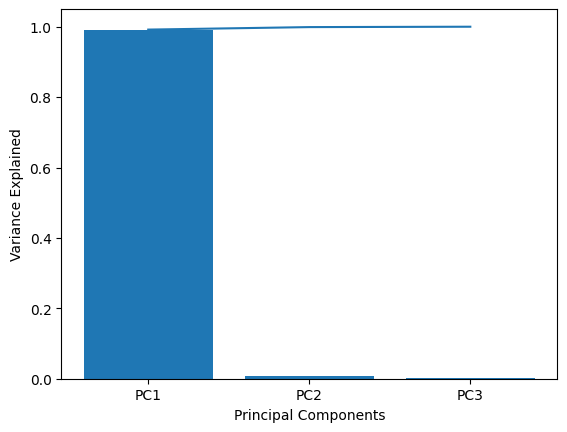

In [29]:
# The scree plot
import matplotlib.pyplot as plt
import numpy as np
x = []
for i in range(0, len(model.explainedVariance)):
    x.append('PC' + str(i + 1))
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.bar(x, y)
plt.plot(x, z)

From the above graph, the first principal component explains 99% of the variance in the data because we did not scale our DataFrame before we used PCA.

In [30]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

#assemble and scale individual columns to one column - 'features2'
def scaled_assemble_vectors(df, features_list, target_variable_name):
    stages = []
    assembler = VectorAssembler(inputCols=features_list, outputCol='assembled_features') #assemble vectors
    scaler = StandardScaler(inputCol=assembler.getOutputCol(), outputCol='features2')
    stages = [assembler, scaler]
    selectedCols = [target_variable_name, 'features2'] + features_list #select all the columns + target + newly created 'features' column
    pipeline = Pipeline(stages=stages) #use pipeline to process sequentially
    scaleAssembleModel = pipeline.fit(df) #assembler model
    df = scaleAssembleModel.transform(df).select(selectedCols) #apply assembler model on data
    return df
features_list = df.columns
features_list.remove(target_variable_name)
df = scaled_assemble_vectors(df, features_list, target_variable_name)

from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors

pca = PCA(k=3, inputCol="features2", outputCol="pcaFeatures")
model = pca.fit(df)

result = model.transform(df).select("pcaFeatures")
result.show(truncate=False)

+------------------------------------------------------------+
|pcaFeatures                                                 |
+------------------------------------------------------------+
|[-0.6567808835228053,4.312194871155298,-4.393764846980897]  |
|[-0.5905533920179782,2.7430023739115263,-2.0129736282025603]|
|[-0.7923309293106011,2.42851782220271,-1.4128758397245442]  |
|[-0.7779852947451467,4.2983026320660285,-5.322505502928544] |
|[-0.5280039534401372,6.559141503669074,-1.4081500208397857] |
|[-0.7028277580737633,2.7093407342344875,-3.226355647066133] |
|[-0.810487232779213,1.4290210013445708,-1.6199354413340639] |
|[-0.9758735335487276,2.8620448590159584,0.4335559756415577] |
|[-0.7126916038562823,5.17563771639752,-4.531453571469942]   |
|[-0.593913202612401,2.7467852504302575,-2.0709944257197637] |
|[-0.4836720278657366,2.5845022963066207,-0.8133472106594234]|
|[-0.5574665926506133,2.0798200304073173,-1.1695266299980627]|
|[-0.6052039081600498,3.494381285319365,-3.060655824796

When PCA is run with the newly created DataFrame from the preceding code, the variance explained by the first component is changed drastically.

In [31]:
model.pc.toArray()

array([[-0.004235  ,  0.31145353, -0.26369491],
       [ 0.03423185,  0.1928538 , -0.09378775],
       [-0.08159571,  0.00735314, -0.01093587],
       [ 0.02258652,  0.01207569,  0.09783498],
       [-0.09750453, -0.01505392, -0.13223208],
       [ 0.38906235, -0.10676363, -0.10055607],
       [ 0.32421309, -0.05649281, -0.11841411],
       [ 0.02062378,  0.22986117,  0.17519785],
       [ 0.02465328, -0.06652983,  0.30496446],
       [-0.01528388,  0.19502562, -0.27178677],
       [-0.03590056, -0.0599626 ,  0.08395041],
       [ 0.00319029,  0.38740709,  0.17909603],
       [-0.03722061, -0.13065229,  0.06100361],
       [-0.15724617, -0.00297912, -0.30082714],
       [ 0.18201491,  0.29037062,  0.1860691 ],
       [ 0.40477716, -0.02040979, -0.0694982 ],
       [-0.004235  ,  0.31145353, -0.26369491],
       [ 0.03423185,  0.1928538 , -0.09378775],
       [-0.08159571,  0.00735314, -0.01093587],
       [ 0.02258652,  0.01207569,  0.09783498],
       [-0.09750453, -0.01505392, -0.132

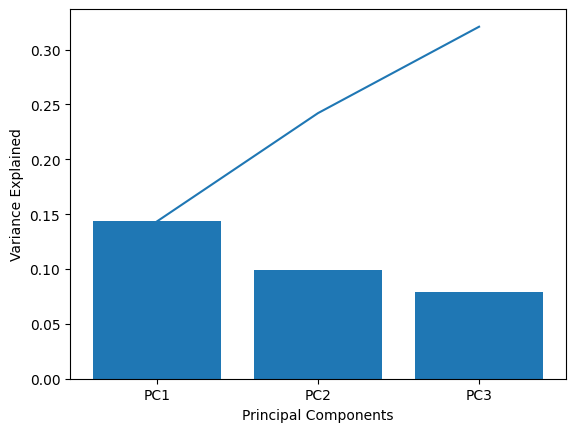

In [32]:
# The scree plot
import matplotlib.pyplot as plt
import numpy as np
x = []
for i in range(0, len(model.explainedVariance)):
    x.append('PC' + str(i + 1))
y = np.array(model.explainedVariance)
z = np.cumsum(model.explainedVariance)
plt.xlabel('Principal Components')
plt.ylabel('Variance Explained')
plt.bar(x, y)
plt.plot(x, z)

SVD -  Any matrix can be decomposed using SVD which is a more stable algorithm.
SVDs are used more for image data compression and in image recovery.

In [33]:
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg.distributed import RowMatrix

# convert DataFrame to rdd
df_svd_vector = df.rdd.map(lambda x: x['features'].toArray())
mat = RowMatrix(df_svd_vector)

# Compute the top 5 singular values and corresponding singular vectors.
svd = mat.computeSVD(5, computeU=True)
U = svd.U       # The U factor is a RowMatrix.
s = svd.s       # The singular values are stored in a local dense vector.
V = svd.V       # The V factor is a local dense matrix.

In [34]:
print("U:", U)
print("s:", s)
print("V:", V)

U: <pyspark.mllib.linalg.distributed.RowMatrix object at 0x7879d8c7afe0>
s: [709656.9402544986,74266.71444460031,22052.822728476745,6458.186158191573,1846.0544468005473]
V: DenseMatrix([[-5.32045026e-03,  7.17134065e-02, -6.66155882e-02,
               9.24391757e-01,  3.59273745e-01],
             [-9.99410373e-01, -3.41100513e-02,  2.65017997e-03,
              -2.89441790e-03, -6.24622758e-05],
             [-1.95484507e-03,  2.74592236e-02, -2.00435750e-02,
               3.52915009e-01, -9.30413502e-01],
             [-3.34805136e-02,  9.93450259e-01,  8.25928509e-02,
              -7.15063617e-02,  4.44990809e-04],
             [-3.27512126e-04,  4.37805988e-03, -2.67568306e-03,
               6.55601660e-02, -7.11682726e-02],
             [-5.04431069e-03,  7.70165284e-02, -9.94042767e-01,
              -7.57844715e-02, -5.18910230e-03],
             [-8.19443306e-05,  1.06911241e-03, -1.06408893e-02,
               2.24222659e-03,  2.92603705e-03],
             [-3.47212922e-04

# Built-in Variable Selection Process: With Target
Chi-Square is called a "goodness of fit" statistic. It used the Chi-Squared test of independence to select the best features. Useful when dealing with categorical variables. Continuous variables can also be used but binning them into groups first is necessary. It does not measure the strength of relationship.

In [35]:
#select only categorical features present in the dataset
features_list = char_vars #this option is used only for ChiSqselector
#run assembled vectors before running this code with the updated features
list

from pyspark.ml.feature import ChiSqSelector
from pyspark.ml.linalg import Vectors

#chisqselector instance initiation
selector = ChiSqSelector(numTopFeatures=6, featuresCol="features",
                         outputCol="selectedFeatures", labelCol="y")
#fit on the data
chi_selector = selector.fit(df)
#result datasets
result = chi_selector.transform(df)
#outputs
print("ChiSqSelector output with top %d features selected" % selector.getNumTopFeatures())
print("Selected Indices: ", chi_selector.selectedFeatures)
features_df['chisq_importance'] = features_df['idx'].apply(lambda x: 1 if x in chi_selector.selectedFeatures else 0)
print(features_df)

ChiSqSelector output with top 6 features selected
Selected Indices:  [0, 1, 2, 3, 4, 5]
                                                vals  idx       name  \
0  [blue-collar, management, technician, admin., ...    7        job   
1             [married, single, divorced, __unknown]    8    marital   
2  [secondary, tertiary, primary, unknown, __unkn...    9  education   
3                               [no, yes, __unknown]   10    default   
4                               [yes, no, __unknown]   11    housing   
5                               [no, yes, __unknown]   12       loan   
6          [cellular, unknown, telephone, __unknown]   13    contact   
7  [may, jul, aug, jun, nov, apr, feb, jan, oct, ...   14      month   
8      [unknown, failure, other, success, __unknown]   15   poutcome   

   chisq_importance  
0                 0  
1                 0  
2                 0  
3                 0  
4                 0  
5                 0  
6                 0  
7              

In [36]:
from pyspark.ml.classification import RandomForestClassifier
rf = RandomForestClassifier(featuresCol='features', labelCol=target_variable_name)
rf_model = rf.fit(df)
rf_model.featureImportances

SparseVector(16, {0: 0.0269, 1: 0.0059, 2: 0.0038, 3: 0.495, 4: 0.005, 5: 0.024, 6: 0.0337, 7: 0.0062, 8: 0.002, 9: 0.002, 11: 0.0172, 12: 0.0006, 13: 0.0252, 14: 0.1038, 15: 0.2488})

In [37]:
import pandas as pd
for k, v in df.schema["features"].metadata["ml_attr"]["attrs"].items():
    features_df = pd.DataFrame(v)

#temporary output rf_output
rf_output = rf_model.featureImportances
features_df['Importance'] = features_df['idx'].apply(lambda x: rf_output[x]
if x in rf_output.indices else 0)

#sort values based on descending importance feature
features_df.sort_values("Importance", ascending=False, inplace=True)

Text(0, 0.5, 'Variable Importance')

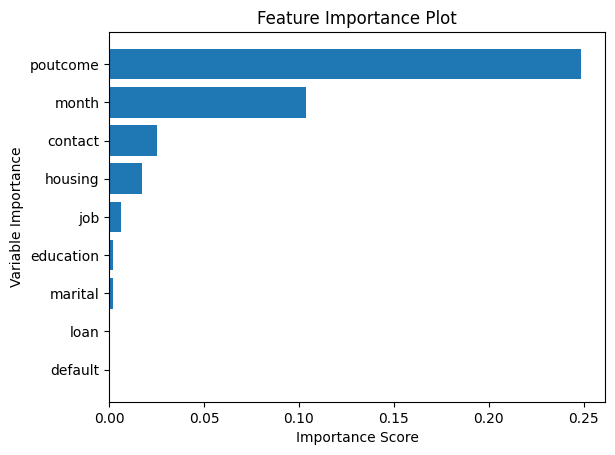

In [38]:
import matplotlib.pyplot as plt

#just for plotting purposes sort it to ascending
features_df.sort_values("Importance", ascending=True, inplace=True)
plt.barh(features_df['name'], features_df['Importance'])
plt.title("Feature Importance Plot")
plt.xlabel("Importance Score")
plt.ylabel("Variable Importance")

From the above, the variable poutcome is the most important one followed by month, contact and so forth...

When dealing with large datasets, Random Forest-based feature selection is better suited. One drawback in using tree-based methods is that it uses the training dataset to calculate the feature importance which can inflate the importance of numeric and high-cardinality variables. The solution is to use permutation importance, which uses the test data to calculate the feature importance.